   ## **Annotations of different emotions:**
   
Anger : 0

Fear : 1 

Joy : 2 

Love : 3 

Sadness : 4

Surprise : 5

## 1. **Importing and Installing required libraries**

In [ ]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 14.3 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [ ]:
# importing the dataset 
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('test.csv')
df_val=pd.read_csv('validation.csv')

In [ ]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


In [ ]:
df_full.shape

(20000, 2)

# 2. Doing some text preprocessing 

In [ ]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    # df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
 
    return(df)

In [ ]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
df_cleaned = df_cleaned.copy()

In [ ]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))

In [ ]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [ ]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [ ]:
encoded_dict  = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

In [ ]:
df_cleaned.num_words.max()

66

In [ ]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [ ]:
data_train.shape

(14000, 3)

In [ ]:
data_test.shape

(6000, 3)

In [ ]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

# 3. Now lets load the model 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [ ]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/content/bert-model.zip'

In [ ]:
tokenizer('I will be kaggle grandmaster')

{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
max_len = 70
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
optimizer =tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 4. Model fitting and then evaluation

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=1,
    batch_size=36
)

  1/389 [..............................] - ETA: 9:04 - loss: 3.7951 - balanced_accuracy: 0.0000e+00

  2/389 [..............................] - ETA: 5:14 - loss: 3.0217 - balanced_accuracy: 0.0278    

  3/389 [..............................] - ETA: 5:12 - loss: 2.5864 - balanced_accuracy: 0.1111

  4/389 [..............................] - ETA: 5:14 - loss: 2.3449 - balanced_accuracy: 0.1667

  5/389 [..............................] - ETA: 5:13 - loss: 2.1990 - balanced_accuracy: 0.1889

  6/389 [..............................] - ETA: 5:13 - loss: 2.0856 - balanced_accuracy: 0.2407

  7/389 [..............................] - ETA: 5:25 - loss: 2.0406 - balanced_accuracy: 0.2619

  8/389 [..............................] - ETA: 5:35 - loss: 1.9963 - balanced_accuracy: 0.2674

  9/389 [..............................] - ETA: 5:48 - loss: 1.9497 - balanced_accuracy: 0.2747

 10/389 [..............................] - ETA: 5:43 - loss: 1.9065 - balanced_accuracy: 0.2778

 11/389 [..............................] - ETA: 5:40 - loss: 1.8651 - balanced_accuracy: 0.2929

 12/389 [..............................] - ETA: 5:37 - loss: 1.8510 - balanced_accuracy: 0.2986

 13/389 [>.............................] - ETA: 5:35 - loss: 1.8372 - balanced_accuracy: 0.3077

 14/389 [>.............................] - ETA: 5:33 - loss: 1.8254 - balanced_accuracy: 0.3016

 15/389 [>.............................] - ETA: 5:31 - loss: 1.8081 - balanced_accuracy: 0.3019

 16/389 [>.............................] - ETA: 5:29 - loss: 1.7950 - balanced_accuracy: 0.3056

 17/389 [>.............................] - ETA: 5:27 - loss: 1.7699 - balanced_accuracy: 0.3186

 18/389 [>.............................] - ETA: 5:25 - loss: 1.7564 - balanced_accuracy: 0.3194

 19/389 [>.............................] - ETA: 5:23 - loss: 1.7459 - balanced_accuracy: 0.3246

 20/389 [>.............................] - ETA: 5:21 - loss: 1.7352 - balanced_accuracy: 0.3361

 21/389 [>.............................] - ETA: 5:21 - loss: 1.7278 - balanced_accuracy: 0.3399

 22/389 [>.............................] - ETA: 5:22 - loss: 1.7185 - balanced_accuracy: 0.3447

 23/389 [>.............................] - ETA: 5:25 - loss: 1.7039 - balanced_accuracy: 0.3551

 24/389 [>.............................] - ETA: 5:26 - loss: 1.6894 - balanced_accuracy: 0.3600

 25/389 [>.............................] - ETA: 5:25 - loss: 1.6837 - balanced_accuracy: 0.3644

 26/389 [=>............................] - ETA: 5:24 - loss: 1.6708 - balanced_accuracy: 0.3675

 27/389 [=>............................] - ETA: 5:22 - loss: 1.6739 - balanced_accuracy: 0.3704

 28/389 [=>............................] - ETA: 5:20 - loss: 1.6721 - balanced_accuracy: 0.3690

 29/389 [=>............................] - ETA: 5:18 - loss: 1.6687 - balanced_accuracy: 0.3678

 30/389 [=>............................] - ETA: 5:17 - loss: 1.6655 - balanced_accuracy: 0.3694

 31/389 [=>............................] - ETA: 5:15 - loss: 1.6588 - balanced_accuracy: 0.3728

 32/389 [=>............................] - ETA: 5:14 - loss: 1.6520 - balanced_accuracy: 0.3776

 33/389 [=>............................] - ETA: 5:12 - loss: 1.6401 - balanced_accuracy: 0.3855

 34/389 [=>............................] - ETA: 5:11 - loss: 1.6365 - balanced_accuracy: 0.3856

 35/389 [=>............................] - ETA: 5:10 - loss: 1.6262 - balanced_accuracy: 0.3921

 36/389 [=>............................] - ETA: 5:09 - loss: 1.6233 - balanced_accuracy: 0.3912

 37/389 [=>............................] - ETA: 5:10 - loss: 1.6141 - balanced_accuracy: 0.3971

 38/389 [=>............................] - ETA: 5:12 - loss: 1.6081 - balanced_accuracy: 0.3991

 39/389 [==>...........................] - ETA: 5:12 - loss: 1.6001 - balanced_accuracy: 0.4053

 40/389 [==>...........................] - ETA: 5:10 - loss: 1.5935 - balanced_accuracy: 0.4097

 41/389 [==>...........................] - ETA: 5:09 - loss: 1.5887 - balanced_accuracy: 0.4106

 42/389 [==>...........................] - ETA: 5:08 - loss: 1.5800 - balanced_accuracy: 0.4120

 43/389 [==>...........................] - ETA: 5:10 - loss: 1.5718 - balanced_accuracy: 0.4167

 44/389 [==>...........................] - ETA: 5:12 - loss: 1.5611 - balanced_accuracy: 0.4223

 45/389 [==>...........................] - ETA: 5:13 - loss: 1.5619 - balanced_accuracy: 0.4235

 46/389 [==>...........................] - ETA: 5:12 - loss: 1.5530 - balanced_accuracy: 0.4269

 47/389 [==>...........................] - ETA: 5:11 - loss: 1.5478 - balanced_accuracy: 0.4291

 48/389 [==>...........................] - ETA: 5:09 - loss: 1.5426 - balanced_accuracy: 0.4317

 49/389 [==>...........................] - ETA: 5:08 - loss: 1.5313 - balanced_accuracy: 0.4365

 50/389 [==>...........................] - ETA: 5:08 - loss: 1.5209 - balanced_accuracy: 0.4411

 51/389 [==>...........................] - ETA: 5:08 - loss: 1.5114 - balanced_accuracy: 0.4450

 52/389 [===>..........................] - ETA: 5:08 - loss: 1.5036 - balanced_accuracy: 0.4487

 53/389 [===>..........................] - ETA: 5:07 - loss: 1.4963 - balanced_accuracy: 0.4507

 54/389 [===>..........................] - ETA: 5:06 - loss: 1.4917 - balanced_accuracy: 0.4527

 55/389 [===>..........................] - ETA: 5:04 - loss: 1.4913 - balanced_accuracy: 0.4525

 56/389 [===>..........................] - ETA: 5:03 - loss: 1.4831 - balanced_accuracy: 0.4559

 57/389 [===>..........................] - ETA: 5:01 - loss: 1.4764 - balanced_accuracy: 0.4571

 58/389 [===>..........................] - ETA: 5:00 - loss: 1.4737 - balanced_accuracy: 0.4593

 59/389 [===>..........................] - ETA: 4:58 - loss: 1.4655 - balanced_accuracy: 0.4623

 60/389 [===>..........................] - ETA: 4:57 - loss: 1.4547 - balanced_accuracy: 0.4676

 61/389 [===>..........................] - ETA: 4:56 - loss: 1.4510 - balanced_accuracy: 0.4690

 62/389 [===>..........................] - ETA: 4:55 - loss: 1.4458 - balanced_accuracy: 0.4713

 63/389 [===>..........................] - ETA: 4:53 - loss: 1.4399 - balanced_accuracy: 0.4727

 64/389 [===>..........................] - ETA: 4:53 - loss: 1.4350 - balanced_accuracy: 0.4748

 65/389 [====>.........................] - ETA: 4:52 - loss: 1.4294 - balanced_accuracy: 0.4774

 66/389 [====>.........................] - ETA: 4:53 - loss: 1.4271 - balanced_accuracy: 0.4764

 67/389 [====>.........................] - ETA: 4:52 - loss: 1.4168 - balanced_accuracy: 0.4809

 68/389 [====>.........................] - ETA: 4:51 - loss: 1.4093 - balanced_accuracy: 0.4845

 69/389 [====>.........................] - ETA: 4:50 - loss: 1.4048 - balanced_accuracy: 0.4863

 70/389 [====>.........................] - ETA: 4:48 - loss: 1.3969 - balanced_accuracy: 0.4893

 71/389 [====>.........................] - ETA: 4:47 - loss: 1.3890 - balanced_accuracy: 0.4930

 72/389 [====>.........................] - ETA: 4:46 - loss: 1.3813 - balanced_accuracy: 0.4961

 73/389 [====>.........................] - ETA: 4:44 - loss: 1.3733 - balanced_accuracy: 0.5000

 74/389 [====>.........................] - ETA: 4:43 - loss: 1.3685 - balanced_accuracy: 0.5011

 75/389 [====>.........................] - ETA: 4:42 - loss: 1.3618 - balanced_accuracy: 0.5030

 76/389 [====>.........................] - ETA: 4:41 - loss: 1.3587 - balanced_accuracy: 0.5040

 77/389 [====>.........................] - ETA: 4:40 - loss: 1.3506 - balanced_accuracy: 0.5072

 78/389 [=====>........................] - ETA: 4:38 - loss: 1.3432 - balanced_accuracy: 0.5096

 79/389 [=====>........................] - ETA: 4:38 - loss: 1.3372 - balanced_accuracy: 0.5123

 80/389 [=====>........................] - ETA: 4:37 - loss: 1.3324 - balanced_accuracy: 0.5132

 81/389 [=====>........................] - ETA: 4:38 - loss: 1.3274 - balanced_accuracy: 0.5154

 82/389 [=====>........................] - ETA: 4:37 - loss: 1.3230 - balanced_accuracy: 0.5183

 83/389 [=====>........................] - ETA: 4:36 - loss: 1.3163 - balanced_accuracy: 0.5211

 84/389 [=====>........................] - ETA: 4:35 - loss: 1.3104 - balanced_accuracy: 0.5231

 85/389 [=====>........................] - ETA: 4:34 - loss: 1.3042 - balanced_accuracy: 0.5248

 86/389 [=====>........................] - ETA: 4:33 - loss: 1.2999 - balanced_accuracy: 0.5271

 87/389 [=====>........................] - ETA: 4:32 - loss: 1.2950 - balanced_accuracy: 0.5294

 88/389 [=====>........................] - ETA: 4:30 - loss: 1.2887 - balanced_accuracy: 0.5328

 89/389 [=====>........................] - ETA: 4:29 - loss: 1.2825 - balanced_accuracy: 0.5350

 90/389 [=====>........................] - ETA: 4:28 - loss: 1.2777 - balanced_accuracy: 0.5364

 91/389 [======>.......................] - ETA: 4:27 - loss: 1.2719 - balanced_accuracy: 0.5394

 92/389 [======>.......................] - ETA: 4:26 - loss: 1.2634 - balanced_accuracy: 0.5426

 93/389 [======>.......................] - ETA: 4:25 - loss: 1.2580 - balanced_accuracy: 0.5445

 94/389 [======>.......................] - ETA: 4:24 - loss: 1.2552 - balanced_accuracy: 0.5455

 95/389 [======>.......................] - ETA: 4:23 - loss: 1.2501 - balanced_accuracy: 0.5482

 96/389 [======>.......................] - ETA: 4:23 - loss: 1.2445 - balanced_accuracy: 0.5506

 97/389 [======>.......................] - ETA: 4:23 - loss: 1.2364 - balanced_accuracy: 0.5541

 98/389 [======>.......................] - ETA: 4:21 - loss: 1.2299 - balanced_accuracy: 0.5570

 99/389 [======>.......................] - ETA: 4:20 - loss: 1.2241 - balanced_accuracy: 0.5589

100/389 [======>.......................] - ETA: 4:19 - loss: 1.2190 - balanced_accuracy: 0.5614

101/389 [======>.......................] - ETA: 4:18 - loss: 1.2158 - balanced_accuracy: 0.5624

102/389 [======>.......................] - ETA: 4:17 - loss: 1.2113 - balanced_accuracy: 0.5640

103/389 [======>.......................] - ETA: 4:16 - loss: 1.2053 - balanced_accuracy: 0.5663

104/389 [=======>......................] - ETA: 4:15 - loss: 1.2024 - balanced_accuracy: 0.5673

105/389 [=======>......................] - ETA: 4:14 - loss: 1.1981 - balanced_accuracy: 0.5685

106/389 [=======>......................] - ETA: 4:13 - loss: 1.1994 - balanced_accuracy: 0.5687

107/389 [=======>......................] - ETA: 4:11 - loss: 1.1930 - balanced_accuracy: 0.5717

108/389 [=======>......................] - ETA: 4:10 - loss: 1.1910 - balanced_accuracy: 0.5723

109/389 [=======>......................] - ETA: 4:10 - loss: 1.1843 - balanced_accuracy: 0.5744

110/389 [=======>......................] - ETA: 4:09 - loss: 1.1820 - balanced_accuracy: 0.5753

111/389 [=======>......................] - ETA: 4:09 - loss: 1.1754 - balanced_accuracy: 0.5773

112/389 [=======>......................] - ETA: 4:08 - loss: 1.1717 - balanced_accuracy: 0.5789

113/389 [=======>......................] - ETA: 4:07 - loss: 1.1654 - balanced_accuracy: 0.5816

114/389 [=======>......................] - ETA: 4:06 - loss: 1.1635 - balanced_accuracy: 0.5833

115/389 [=======>......................] - ETA: 4:05 - loss: 1.1589 - balanced_accuracy: 0.5848

116/389 [=======>......................] - ETA: 4:04 - loss: 1.1523 - balanced_accuracy: 0.5876

117/389 [========>.....................] - ETA: 4:03 - loss: 1.1474 - balanced_accuracy: 0.5893

118/389 [========>.....................] - ETA: 4:02 - loss: 1.1431 - balanced_accuracy: 0.5904

119/389 [========>.....................] - ETA: 4:01 - loss: 1.1397 - balanced_accuracy: 0.5922

120/389 [========>.....................] - ETA: 4:00 - loss: 1.1346 - balanced_accuracy: 0.5942

121/389 [========>.....................] - ETA: 3:59 - loss: 1.1289 - balanced_accuracy: 0.5966

122/389 [========>.....................] - ETA: 3:58 - loss: 1.1222 - balanced_accuracy: 0.5988

123/389 [========>.....................] - ETA: 3:56 - loss: 1.1161 - balanced_accuracy: 0.6007

124/389 [========>.....................] - ETA: 3:56 - loss: 1.1118 - balanced_accuracy: 0.6026

125/389 [========>.....................] - ETA: 3:55 - loss: 1.1084 - balanced_accuracy: 0.6038

126/389 [========>.....................] - ETA: 3:55 - loss: 1.1051 - balanced_accuracy: 0.6045

127/389 [========>.....................] - ETA: 3:54 - loss: 1.0997 - balanced_accuracy: 0.6065

128/389 [========>.....................] - ETA: 3:53 - loss: 1.0962 - balanced_accuracy: 0.6076

129/389 [========>.....................] - ETA: 3:52 - loss: 1.0925 - balanced_accuracy: 0.6090

130/389 [=========>....................] - ETA: 3:51 - loss: 1.0889 - balanced_accuracy: 0.6105

131/389 [=========>....................] - ETA: 3:50 - loss: 1.0837 - balanced_accuracy: 0.6126

132/389 [=========>....................] - ETA: 3:49 - loss: 1.0792 - balanced_accuracy: 0.6145

133/389 [=========>....................] - ETA: 3:48 - loss: 1.0741 - balanced_accuracy: 0.6163

134/389 [=========>....................] - ETA: 3:47 - loss: 1.0695 - balanced_accuracy: 0.6177

135/389 [=========>....................] - ETA: 3:46 - loss: 1.0668 - balanced_accuracy: 0.6191

136/389 [=========>....................] - ETA: 3:45 - loss: 1.0638 - balanced_accuracy: 0.6205

137/389 [=========>....................] - ETA: 3:44 - loss: 1.0587 - balanced_accuracy: 0.6223

138/389 [=========>....................] - ETA: 3:43 - loss: 1.0556 - balanced_accuracy: 0.6236

139/389 [=========>....................] - ETA: 3:42 - loss: 1.0529 - balanced_accuracy: 0.6251

140/389 [=========>....................] - ETA: 3:42 - loss: 1.0504 - balanced_accuracy: 0.6262

141/389 [=========>....................] - ETA: 3:41 - loss: 1.0453 - balanced_accuracy: 0.6281

142/389 [=========>....................] - ETA: 3:40 - loss: 1.0410 - balanced_accuracy: 0.6297

143/389 [==========>...................] - ETA: 3:39 - loss: 1.0363 - balanced_accuracy: 0.6315

144/389 [==========>...................] - ETA: 3:38 - loss: 1.0331 - balanced_accuracy: 0.6327

145/389 [==========>...................] - ETA: 3:37 - loss: 1.0272 - balanced_accuracy: 0.6351

146/389 [==========>...................] - ETA: 3:36 - loss: 1.0231 - balanced_accuracy: 0.6364

147/389 [==========>...................] - ETA: 3:35 - loss: 1.0196 - balanced_accuracy: 0.6381

148/389 [==========>...................] - ETA: 3:34 - loss: 1.0169 - balanced_accuracy: 0.6393

149/389 [==========>...................] - ETA: 3:33 - loss: 1.0139 - balanced_accuracy: 0.6406

150/389 [==========>...................] - ETA: 3:32 - loss: 1.0106 - balanced_accuracy: 0.6419

151/389 [==========>...................] - ETA: 3:32 - loss: 1.0059 - balanced_accuracy: 0.6437

152/389 [==========>...................] - ETA: 3:31 - loss: 1.0039 - balanced_accuracy: 0.6440

153/389 [==========>...................] - ETA: 3:30 - loss: 0.9993 - balanced_accuracy: 0.6456

154/389 [==========>...................] - ETA: 3:29 - loss: 0.9957 - balanced_accuracy: 0.6468

155/389 [==========>...................] - ETA: 3:28 - loss: 0.9923 - balanced_accuracy: 0.6478

156/389 [===========>..................] - ETA: 3:28 - loss: 0.9881 - balanced_accuracy: 0.6496

157/389 [===========>..................] - ETA: 3:27 - loss: 0.9849 - balanced_accuracy: 0.6504

158/389 [===========>..................] - ETA: 3:26 - loss: 0.9826 - balanced_accuracy: 0.6512

159/389 [===========>..................] - ETA: 3:25 - loss: 0.9795 - balanced_accuracy: 0.6525

160/389 [===========>..................] - ETA: 3:24 - loss: 0.9754 - balanced_accuracy: 0.6538

161/389 [===========>..................] - ETA: 3:23 - loss: 0.9710 - balanced_accuracy: 0.6553

162/389 [===========>..................] - ETA: 3:22 - loss: 0.9673 - balanced_accuracy: 0.6566

163/389 [===========>..................] - ETA: 3:21 - loss: 0.9629 - balanced_accuracy: 0.6581

164/389 [===========>..................] - ETA: 3:20 - loss: 0.9627 - balanced_accuracy: 0.6592

165/389 [===========>..................] - ETA: 3:19 - loss: 0.9588 - balanced_accuracy: 0.6604

166/389 [===========>..................] - ETA: 3:18 - loss: 0.9559 - balanced_accuracy: 0.6615

167/389 [===========>..................] - ETA: 3:17 - loss: 0.9534 - balanced_accuracy: 0.6625

168/389 [===========>..................] - ETA: 3:16 - loss: 0.9507 - balanced_accuracy: 0.6639

169/389 [============>.................] - ETA: 3:15 - loss: 0.9473 - balanced_accuracy: 0.6650

170/389 [============>.................] - ETA: 3:15 - loss: 0.9440 - balanced_accuracy: 0.6665

171/389 [============>.................] - ETA: 3:14 - loss: 0.9402 - balanced_accuracy: 0.6678

172/389 [============>.................] - ETA: 3:13 - loss: 0.9379 - balanced_accuracy: 0.6686

173/389 [============>.................] - ETA: 3:12 - loss: 0.9346 - balanced_accuracy: 0.6696

174/389 [============>.................] - ETA: 3:11 - loss: 0.9320 - balanced_accuracy: 0.6705

175/389 [============>.................] - ETA: 3:10 - loss: 0.9296 - balanced_accuracy: 0.6711

176/389 [============>.................] - ETA: 3:09 - loss: 0.9266 - balanced_accuracy: 0.6719

177/389 [============>.................] - ETA: 3:08 - loss: 0.9231 - balanced_accuracy: 0.6733

178/389 [============>.................] - ETA: 3:07 - loss: 0.9206 - balanced_accuracy: 0.6740

179/389 [============>.................] - ETA: 3:06 - loss: 0.9169 - balanced_accuracy: 0.6752

180/389 [============>.................] - ETA: 3:05 - loss: 0.9146 - balanced_accuracy: 0.6764

181/389 [============>.................] - ETA: 3:04 - loss: 0.9115 - balanced_accuracy: 0.6774

182/389 [=============>................] - ETA: 3:04 - loss: 0.9074 - balanced_accuracy: 0.6790

183/389 [=============>................] - ETA: 3:03 - loss: 0.9050 - balanced_accuracy: 0.6796

184/389 [=============>................] - ETA: 3:02 - loss: 0.9020 - balanced_accuracy: 0.6806

185/389 [=============>................] - ETA: 3:01 - loss: 0.9001 - balanced_accuracy: 0.6814

186/389 [=============>................] - ETA: 3:01 - loss: 0.8962 - balanced_accuracy: 0.6828

187/389 [=============>................] - ETA: 3:00 - loss: 0.8931 - balanced_accuracy: 0.6836

188/389 [=============>................] - ETA: 2:59 - loss: 0.8906 - balanced_accuracy: 0.6841

189/389 [=============>................] - ETA: 2:58 - loss: 0.8875 - balanced_accuracy: 0.6855

190/389 [=============>................] - ETA: 2:57 - loss: 0.8844 - balanced_accuracy: 0.6865

191/389 [=============>................] - ETA: 2:56 - loss: 0.8823 - balanced_accuracy: 0.6870

192/389 [=============>................] - ETA: 2:55 - loss: 0.8786 - balanced_accuracy: 0.6882

193/389 [=============>................] - ETA: 2:54 - loss: 0.8763 - balanced_accuracy: 0.6891

194/389 [=============>................] - ETA: 2:53 - loss: 0.8740 - balanced_accuracy: 0.6900

195/389 [==============>...............] - ETA: 2:52 - loss: 0.8720 - balanced_accuracy: 0.6906

196/389 [==============>...............] - ETA: 2:51 - loss: 0.8695 - balanced_accuracy: 0.6916

197/389 [==============>...............] - ETA: 2:50 - loss: 0.8666 - balanced_accuracy: 0.6925

198/389 [==============>...............] - ETA: 2:49 - loss: 0.8651 - balanced_accuracy: 0.6929

199/389 [==============>...............] - ETA: 2:48 - loss: 0.8627 - balanced_accuracy: 0.6936

200/389 [==============>...............] - ETA: 2:48 - loss: 0.8607 - balanced_accuracy: 0.6943

201/389 [==============>...............] - ETA: 2:47 - loss: 0.8591 - balanced_accuracy: 0.6947

202/389 [==============>...............] - ETA: 2:46 - loss: 0.8569 - balanced_accuracy: 0.6953

203/389 [==============>...............] - ETA: 2:45 - loss: 0.8538 - balanced_accuracy: 0.6961

204/389 [==============>...............] - ETA: 2:44 - loss: 0.8512 - balanced_accuracy: 0.6970

205/389 [==============>...............] - ETA: 2:43 - loss: 0.8485 - balanced_accuracy: 0.6978

206/389 [==============>...............] - ETA: 2:42 - loss: 0.8464 - balanced_accuracy: 0.6985

207/389 [==============>...............] - ETA: 2:42 - loss: 0.8435 - balanced_accuracy: 0.6993

208/389 [===============>..............] - ETA: 2:41 - loss: 0.8409 - balanced_accuracy: 0.7002

209/389 [===============>..............] - ETA: 2:40 - loss: 0.8384 - balanced_accuracy: 0.7010

210/389 [===============>..............] - ETA: 2:39 - loss: 0.8351 - balanced_accuracy: 0.7022

211/389 [===============>..............] - ETA: 2:38 - loss: 0.8327 - balanced_accuracy: 0.7033

212/389 [===============>..............] - ETA: 2:37 - loss: 0.8313 - balanced_accuracy: 0.7039

213/389 [===============>..............] - ETA: 2:36 - loss: 0.8292 - balanced_accuracy: 0.7046

214/389 [===============>..............] - ETA: 2:35 - loss: 0.8269 - balanced_accuracy: 0.7055

215/389 [===============>..............] - ETA: 2:35 - loss: 0.8254 - balanced_accuracy: 0.7059

216/389 [===============>..............] - ETA: 2:34 - loss: 0.8226 - balanced_accuracy: 0.7070

217/389 [===============>..............] - ETA: 2:33 - loss: 0.8198 - balanced_accuracy: 0.7080

218/389 [===============>..............] - ETA: 2:32 - loss: 0.8166 - balanced_accuracy: 0.7092

219/389 [===============>..............] - ETA: 2:31 - loss: 0.8138 - balanced_accuracy: 0.7100

220/389 [===============>..............] - ETA: 2:30 - loss: 0.8117 - balanced_accuracy: 0.7107

221/389 [================>.............] - ETA: 2:29 - loss: 0.8101 - balanced_accuracy: 0.7117

222/389 [================>.............] - ETA: 2:28 - loss: 0.8073 - balanced_accuracy: 0.7128

223/389 [================>.............] - ETA: 2:27 - loss: 0.8065 - balanced_accuracy: 0.7134

224/389 [================>.............] - ETA: 2:26 - loss: 0.8036 - balanced_accuracy: 0.7145

225/389 [================>.............] - ETA: 2:25 - loss: 0.8013 - balanced_accuracy: 0.7154

226/389 [================>.............] - ETA: 2:24 - loss: 0.7982 - balanced_accuracy: 0.7167

227/389 [================>.............] - ETA: 2:24 - loss: 0.7961 - balanced_accuracy: 0.7174

228/389 [================>.............] - ETA: 2:23 - loss: 0.7936 - balanced_accuracy: 0.7186

229/389 [================>.............] - ETA: 2:22 - loss: 0.7913 - balanced_accuracy: 0.7193

230/389 [================>.............] - ETA: 2:21 - loss: 0.7886 - balanced_accuracy: 0.7203

231/389 [================>.............] - ETA: 2:20 - loss: 0.7864 - balanced_accuracy: 0.7211

232/389 [================>.............] - ETA: 2:19 - loss: 0.7838 - balanced_accuracy: 0.7221

233/389 [================>.............] - ETA: 2:19 - loss: 0.7817 - balanced_accuracy: 0.7228

234/389 [=================>............] - ETA: 2:18 - loss: 0.7794 - balanced_accuracy: 0.7238

235/389 [=================>............] - ETA: 2:17 - loss: 0.7774 - balanced_accuracy: 0.7245

236/389 [=================>............] - ETA: 2:16 - loss: 0.7752 - balanced_accuracy: 0.7250

237/389 [=================>............] - ETA: 2:15 - loss: 0.7747 - balanced_accuracy: 0.7252

238/389 [=================>............] - ETA: 2:14 - loss: 0.7723 - balanced_accuracy: 0.7260

239/389 [=================>............] - ETA: 2:13 - loss: 0.7699 - balanced_accuracy: 0.7269

240/389 [=================>............] - ETA: 2:12 - loss: 0.7682 - balanced_accuracy: 0.7274

241/389 [=================>............] - ETA: 2:11 - loss: 0.7658 - balanced_accuracy: 0.7283

242/389 [=================>............] - ETA: 2:10 - loss: 0.7637 - balanced_accuracy: 0.7290

243/389 [=================>............] - ETA: 2:09 - loss: 0.7616 - balanced_accuracy: 0.7299

244/389 [=================>............] - ETA: 2:09 - loss: 0.7604 - balanced_accuracy: 0.7304

245/389 [=================>............] - ETA: 2:08 - loss: 0.7578 - balanced_accuracy: 0.7314

246/389 [=================>............] - ETA: 2:07 - loss: 0.7553 - balanced_accuracy: 0.7322

247/389 [==================>...........] - ETA: 2:06 - loss: 0.7536 - balanced_accuracy: 0.7328

248/389 [==================>...........] - ETA: 2:05 - loss: 0.7515 - balanced_accuracy: 0.7334

249/389 [==================>...........] - ETA: 2:04 - loss: 0.7499 - balanced_accuracy: 0.7338

250/389 [==================>...........] - ETA: 2:03 - loss: 0.7475 - balanced_accuracy: 0.7348

251/389 [==================>...........] - ETA: 2:02 - loss: 0.7453 - balanced_accuracy: 0.7356

252/389 [==================>...........] - ETA: 2:01 - loss: 0.7433 - balanced_accuracy: 0.7362

253/389 [==================>...........] - ETA: 2:00 - loss: 0.7412 - balanced_accuracy: 0.7369

254/389 [==================>...........] - ETA: 2:00 - loss: 0.7386 - balanced_accuracy: 0.7380

255/389 [==================>...........] - ETA: 1:59 - loss: 0.7363 - balanced_accuracy: 0.7388

256/389 [==================>...........] - ETA: 1:58 - loss: 0.7356 - balanced_accuracy: 0.7391

257/389 [==================>...........] - ETA: 1:57 - loss: 0.7334 - balanced_accuracy: 0.7398

258/389 [==================>...........] - ETA: 1:56 - loss: 0.7316 - balanced_accuracy: 0.7405

259/389 [==================>...........] - ETA: 1:55 - loss: 0.7295 - balanced_accuracy: 0.7413

260/389 [===================>..........] - ETA: 1:55 - loss: 0.7268 - balanced_accuracy: 0.7423

261/389 [===================>..........] - ETA: 1:54 - loss: 0.7253 - balanced_accuracy: 0.7428

262/389 [===================>..........] - ETA: 1:53 - loss: 0.7231 - balanced_accuracy: 0.7435

263/389 [===================>..........] - ETA: 1:52 - loss: 0.7208 - balanced_accuracy: 0.7443

264/389 [===================>..........] - ETA: 1:51 - loss: 0.7194 - balanced_accuracy: 0.7448

265/389 [===================>..........] - ETA: 1:50 - loss: 0.7181 - balanced_accuracy: 0.7455

266/389 [===================>..........] - ETA: 1:49 - loss: 0.7164 - balanced_accuracy: 0.7459

267/389 [===================>..........] - ETA: 1:48 - loss: 0.7147 - balanced_accuracy: 0.7466

268/389 [===================>..........] - ETA: 1:48 - loss: 0.7141 - balanced_accuracy: 0.7470

269/389 [===================>..........] - ETA: 1:47 - loss: 0.7117 - balanced_accuracy: 0.7478

270/389 [===================>..........] - ETA: 1:46 - loss: 0.7100 - balanced_accuracy: 0.7485

271/389 [===================>..........] - ETA: 1:45 - loss: 0.7086 - balanced_accuracy: 0.7490

272/389 [===================>..........] - ETA: 1:44 - loss: 0.7083 - balanced_accuracy: 0.7494

273/389 [====================>.........] - ETA: 1:43 - loss: 0.7075 - balanced_accuracy: 0.7498

274/389 [====================>.........] - ETA: 1:42 - loss: 0.7060 - balanced_accuracy: 0.7503

275/389 [====================>.........] - ETA: 1:41 - loss: 0.7046 - balanced_accuracy: 0.7508

276/389 [====================>.........] - ETA: 1:40 - loss: 0.7041 - balanced_accuracy: 0.7510

277/389 [====================>.........] - ETA: 1:40 - loss: 0.7020 - balanced_accuracy: 0.7517

278/389 [====================>.........] - ETA: 1:39 - loss: 0.6999 - balanced_accuracy: 0.7524

279/389 [====================>.........] - ETA: 1:38 - loss: 0.6980 - balanced_accuracy: 0.7531

280/389 [====================>.........] - ETA: 1:37 - loss: 0.6958 - balanced_accuracy: 0.7539

281/389 [====================>.........] - ETA: 1:36 - loss: 0.6941 - balanced_accuracy: 0.7545

282/389 [====================>.........] - ETA: 1:35 - loss: 0.6931 - balanced_accuracy: 0.7549

283/389 [====================>.........] - ETA: 1:34 - loss: 0.6912 - balanced_accuracy: 0.7556

284/389 [====================>.........] - ETA: 1:33 - loss: 0.6906 - balanced_accuracy: 0.7557

285/389 [====================>.........] - ETA: 1:32 - loss: 0.6896 - balanced_accuracy: 0.7557

286/389 [=====================>........] - ETA: 1:31 - loss: 0.6880 - balanced_accuracy: 0.7562

287/389 [=====================>........] - ETA: 1:31 - loss: 0.6866 - balanced_accuracy: 0.7567

288/389 [=====================>........] - ETA: 1:30 - loss: 0.6850 - balanced_accuracy: 0.7572

289/389 [=====================>........] - ETA: 1:29 - loss: 0.6828 - balanced_accuracy: 0.7581

290/389 [=====================>........] - ETA: 1:28 - loss: 0.6813 - balanced_accuracy: 0.7585

291/389 [=====================>........] - ETA: 1:27 - loss: 0.6795 - balanced_accuracy: 0.7592

292/389 [=====================>........] - ETA: 1:26 - loss: 0.6789 - balanced_accuracy: 0.7593

293/389 [=====================>........] - ETA: 1:25 - loss: 0.6770 - balanced_accuracy: 0.7600

294/389 [=====================>........] - ETA: 1:24 - loss: 0.6753 - balanced_accuracy: 0.7604

295/389 [=====================>........] - ETA: 1:23 - loss: 0.6736 - balanced_accuracy: 0.7610

296/389 [=====================>........] - ETA: 1:23 - loss: 0.6723 - balanced_accuracy: 0.7612

297/389 [=====================>........] - ETA: 1:22 - loss: 0.6719 - balanced_accuracy: 0.7615

298/389 [=====================>........] - ETA: 1:21 - loss: 0.6702 - balanced_accuracy: 0.7621

299/389 [======================>.......] - ETA: 1:20 - loss: 0.6686 - balanced_accuracy: 0.7627

300/389 [======================>.......] - ETA: 1:19 - loss: 0.6669 - balanced_accuracy: 0.7632

301/389 [======================>.......] - ETA: 1:18 - loss: 0.6653 - balanced_accuracy: 0.7638

302/389 [======================>.......] - ETA: 1:17 - loss: 0.6635 - balanced_accuracy: 0.7644

303/389 [======================>.......] - ETA: 1:16 - loss: 0.6623 - balanced_accuracy: 0.7649

304/389 [======================>.......] - ETA: 1:15 - loss: 0.6616 - balanced_accuracy: 0.7651

305/389 [======================>.......] - ETA: 1:15 - loss: 0.6598 - balanced_accuracy: 0.7658

306/389 [======================>.......] - ETA: 1:14 - loss: 0.6585 - balanced_accuracy: 0.7662

307/389 [======================>.......] - ETA: 1:13 - loss: 0.6579 - balanced_accuracy: 0.7663

308/389 [======================>.......] - ETA: 1:12 - loss: 0.6572 - balanced_accuracy: 0.7666

309/389 [======================>.......] - ETA: 1:11 - loss: 0.6558 - balanced_accuracy: 0.7670

310/389 [======================>.......] - ETA: 1:10 - loss: 0.6547 - balanced_accuracy: 0.7674

311/389 [======================>.......] - ETA: 1:09 - loss: 0.6534 - balanced_accuracy: 0.7679

312/389 [=======================>......] - ETA: 1:08 - loss: 0.6527 - balanced_accuracy: 0.7683

313/389 [=======================>......] - ETA: 1:07 - loss: 0.6516 - balanced_accuracy: 0.7687

314/389 [=======================>......] - ETA: 1:06 - loss: 0.6497 - balanced_accuracy: 0.7695

315/389 [=======================>......] - ETA: 1:05 - loss: 0.6483 - balanced_accuracy: 0.7699

316/389 [=======================>......] - ETA: 1:05 - loss: 0.6469 - balanced_accuracy: 0.7704

317/389 [=======================>......] - ETA: 1:04 - loss: 0.6456 - balanced_accuracy: 0.7708

318/389 [=======================>......] - ETA: 1:03 - loss: 0.6443 - balanced_accuracy: 0.7711

319/389 [=======================>......] - ETA: 1:02 - loss: 0.6430 - balanced_accuracy: 0.7716

320/389 [=======================>......] - ETA: 1:01 - loss: 0.6413 - balanced_accuracy: 0.7722

321/389 [=======================>......] - ETA: 1:00 - loss: 0.6401 - balanced_accuracy: 0.7725

322/389 [=======================>......] - ETA: 59s - loss: 0.6397 - balanced_accuracy: 0.7727 

323/389 [=======================>......] - ETA: 58s - loss: 0.6381 - balanced_accuracy: 0.7732

324/389 [=======================>......] - ETA: 58s - loss: 0.6373 - balanced_accuracy: 0.7736

325/389 [========================>.....] - ETA: 57s - loss: 0.6363 - balanced_accuracy: 0.7741

326/389 [========================>.....] - ETA: 56s - loss: 0.6350 - balanced_accuracy: 0.7746

327/389 [========================>.....] - ETA: 55s - loss: 0.6338 - balanced_accuracy: 0.7751

328/389 [========================>.....] - ETA: 54s - loss: 0.6323 - balanced_accuracy: 0.7757

329/389 [========================>.....] - ETA: 53s - loss: 0.6312 - balanced_accuracy: 0.7761

330/389 [========================>.....] - ETA: 52s - loss: 0.6301 - balanced_accuracy: 0.7763

331/389 [========================>.....] - ETA: 51s - loss: 0.6291 - balanced_accuracy: 0.7766

332/389 [========================>.....] - ETA: 50s - loss: 0.6288 - balanced_accuracy: 0.7767

333/389 [========================>.....] - ETA: 49s - loss: 0.6278 - balanced_accuracy: 0.7772

334/389 [========================>.....] - ETA: 49s - loss: 0.6269 - balanced_accuracy: 0.7776

335/389 [========================>.....] - ETA: 48s - loss: 0.6255 - balanced_accuracy: 0.7780

336/389 [========================>.....] - ETA: 47s - loss: 0.6239 - balanced_accuracy: 0.7786

337/389 [========================>.....] - ETA: 46s - loss: 0.6231 - balanced_accuracy: 0.7789

338/389 [=========================>....] - ETA: 45s - loss: 0.6218 - balanced_accuracy: 0.7793

339/389 [=========================>....] - ETA: 44s - loss: 0.6205 - balanced_accuracy: 0.7798

340/389 [=========================>....] - ETA: 43s - loss: 0.6189 - balanced_accuracy: 0.7804

341/389 [=========================>....] - ETA: 42s - loss: 0.6176 - balanced_accuracy: 0.7808

342/389 [=========================>....] - ETA: 41s - loss: 0.6168 - balanced_accuracy: 0.7811

343/389 [=========================>....] - ETA: 41s - loss: 0.6158 - balanced_accuracy: 0.7814

344/389 [=========================>....] - ETA: 40s - loss: 0.6147 - balanced_accuracy: 0.7818

345/389 [=========================>....] - ETA: 39s - loss: 0.6137 - balanced_accuracy: 0.7821

346/389 [=========================>....] - ETA: 38s - loss: 0.6123 - balanced_accuracy: 0.7827

347/389 [=========================>....] - ETA: 37s - loss: 0.6112 - balanced_accuracy: 0.7831

348/389 [=========================>....] - ETA: 36s - loss: 0.6102 - balanced_accuracy: 0.7834

349/389 [=========================>....] - ETA: 35s - loss: 0.6093 - balanced_accuracy: 0.7837

350/389 [=========================>....] - ETA: 34s - loss: 0.6081 - balanced_accuracy: 0.7840

351/389 [==========================>...] - ETA: 33s - loss: 0.6068 - balanced_accuracy: 0.7843

352/389 [==========================>...] - ETA: 33s - loss: 0.6061 - balanced_accuracy: 0.7846

353/389 [==========================>...] - ETA: 32s - loss: 0.6049 - balanced_accuracy: 0.7849

354/389 [==========================>...] - ETA: 31s - loss: 0.6040 - balanced_accuracy: 0.7852

355/389 [==========================>...] - ETA: 30s - loss: 0.6027 - balanced_accuracy: 0.7857

356/389 [==========================>...] - ETA: 29s - loss: 0.6016 - balanced_accuracy: 0.7860

357/389 [==========================>...] - ETA: 28s - loss: 0.6006 - balanced_accuracy: 0.7862

358/389 [==========================>...] - ETA: 27s - loss: 0.5993 - balanced_accuracy: 0.7866

359/389 [==========================>...] - ETA: 26s - loss: 0.5978 - balanced_accuracy: 0.7871

360/389 [==========================>...] - ETA: 25s - loss: 0.5966 - balanced_accuracy: 0.7877

361/389 [==========================>...] - ETA: 24s - loss: 0.5953 - balanced_accuracy: 0.7882

362/389 [==========================>...] - ETA: 24s - loss: 0.5942 - balanced_accuracy: 0.7887

363/389 [==========================>...] - ETA: 23s - loss: 0.5928 - balanced_accuracy: 0.7893

364/389 [===========================>..] - ETA: 22s - loss: 0.5915 - balanced_accuracy: 0.7898

365/389 [===========================>..] - ETA: 21s - loss: 0.5901 - balanced_accuracy: 0.7903

366/389 [===========================>..] - ETA: 20s - loss: 0.5895 - balanced_accuracy: 0.7906

367/389 [===========================>..] - ETA: 19s - loss: 0.5889 - balanced_accuracy: 0.7909

368/389 [===========================>..] - ETA: 18s - loss: 0.5879 - balanced_accuracy: 0.7913

369/389 [===========================>..] - ETA: 17s - loss: 0.5874 - balanced_accuracy: 0.7915

370/389 [===========================>..] - ETA: 16s - loss: 0.5872 - balanced_accuracy: 0.7917

371/389 [===========================>..] - ETA: 16s - loss: 0.5866 - balanced_accuracy: 0.7920

372/389 [===========================>..] - ETA: 15s - loss: 0.5852 - balanced_accuracy: 0.7925

373/389 [===========================>..] - ETA: 14s - loss: 0.5841 - balanced_accuracy: 0.7928

374/389 [===========================>..] - ETA: 13s - loss: 0.5829 - balanced_accuracy: 0.7932

375/389 [===========================>..] - ETA: 12s - loss: 0.5819 - balanced_accuracy: 0.7936

376/389 [===========================>..] - ETA: 11s - loss: 0.5808 - balanced_accuracy: 0.7940

377/389 [============================>.] - ETA: 10s - loss: 0.5797 - balanced_accuracy: 0.7943

378/389 [============================>.] - ETA: 9s - loss: 0.5783 - balanced_accuracy: 0.7948 

379/389 [============================>.] - ETA: 8s - loss: 0.5781 - balanced_accuracy: 0.7946

380/389 [============================>.] - ETA: 8s - loss: 0.5774 - balanced_accuracy: 0.7950

381/389 [============================>.] - ETA: 7s - loss: 0.5762 - balanced_accuracy: 0.7953

382/389 [============================>.] - ETA: 6s - loss: 0.5751 - balanced_accuracy: 0.7956

383/389 [============================>.] - ETA: 5s - loss: 0.5743 - balanced_accuracy: 0.7960

384/389 [============================>.] - ETA: 4s - loss: 0.5735 - balanced_accuracy: 0.7964

385/389 [============================>.] - ETA: 3s - loss: 0.5723 - balanced_accuracy: 0.7968

386/389 [============================>.] - ETA: 2s - loss: 0.5718 - balanced_accuracy: 0.7971

387/389 [============================>.] - ETA: 1s - loss: 0.5705 - balanced_accuracy: 0.7975

388/389 [============================>.] - ETA: 0s - loss: 0.5694 - balanced_accuracy: 0.7980

389/389 [==============================] - 380s 975ms/step - loss: 0.5684 - balanced_accuracy: 0.7983 - val_loss: 0.1952 - val_balanced_accuracy: 0.9178


# 5.Prediction Part

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

188/188 [==============================] - 36s 191ms/step


In [ ]:
predicted_raw[0]

array([0.7648307 , 0.99914575, 0.7784101 , 0.2726866 , 0.00135169,
       0.47915518], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([1, 1, 1, ..., 0, 0, 4])

In [ ]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [ ]:
accuracy_score(data_test['label'],y_predicted)

0.9178333333333333

In [ ]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1739
           1       0.98      0.90      0.94      2028
           2       0.77      0.95      0.85       492
           3       0.94      0.89      0.91       813
           4       0.86      0.89      0.87       712
           5       0.83      0.75      0.79       216

    accuracy                           0.92      6000
   macro avg       0.88      0.89      0.89      6000
weighted avg       0.92      0.92      0.92      6000



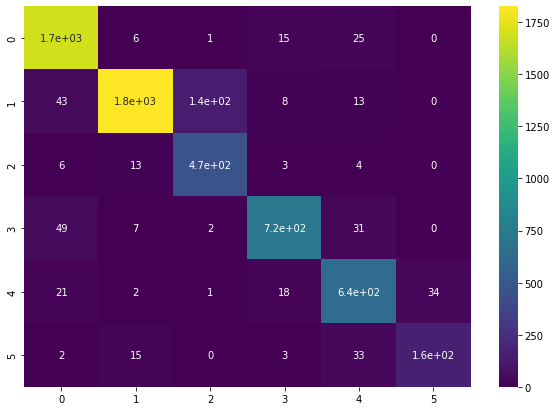

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

# 5. Prediction on custom text

In [ ]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the texti jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week...
1/1 [==============================] - 0s 189ms/step


array([[23.868721,  5.436685,  6.205639, 99.09287 ,  6.860341,  9.255083]],
      dtype=float32)

In [ ]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

anger 23.868721
fear 5.436685
joy 6.205639
love 99.09287
sadness 6.860341
surprise 9.255083


In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

